# Upravljanje znanjem - završni rad

Ak. god. 2021/2022
Nositelji:

- izv. prof. dr. sc. Ana Meštrović  
- dr. sc. Slobodan Beliga  
  
Autor: Andrea Hrelja

## Zadatak
Završni rad iz kolegija Upravljanje znanjem zahtjeva analizu mreže koja je zadana u obliku *edge* i *node* liste. Lista bridova sadrži podatke o početnoj i krajnjoj točki transportne linije/rute te pripadnu težinu (*weight*) koja odgovara broju odrađenih vožnji između pojedina dva odredišta (*ship ports*). Nadalje, lista čvorova sadrži pripadne zemljopisne koordinate za brodske luke zapisane u obliku decimalnih stupnjeva (*decimal degrees*) za latitude i longitude.  

Za interpretaciju rezultata važno je znati i razumjeti na što se dataset odnosi i koje podatke opisuje.
Podatke je potrebno proučiti s ciljem razumijevanja što su čvorovi, veze i težine ako postoje.

## Sažetak

U svrhu analize zadane mreže, svakom je čvoru dodan atribut *country* koji dodatno opisuje svaki čvor. Nakon toga, graf je vizualiziran zbog jednostavnije interpretacije rezultata. Već je u ovoj točki vidljivo da unutar mreže postoji više zajednica. Zatim je svakom čvoru dodijeljena pripadajuća zajednica koristeći Gavin-Newman-ove i Louvaineove metode. Zatim su kreirana problemska pitanja koja će se rješavati i analizirati.  

Dodatno, svakoj je državi i zajednici dodijeljena nasumična boja koja služi za jasniji prikaz atributa čvorova. 

In [1]:
import time
import random
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community as community_gn
import community as community_louvain

edges = pd.read_csv('data/edges.csv', encoding='utf-8')
nodes = pd.read_csv('data/nodes.csv', encoding='utf-8', index_col='ID')

In [2]:
def get_node_country(x):
    lat, lng = x[1], x[0]
    response_json = {'success': False}
    while response_json.get('success', True) == False:
        time.sleep(0.5)
        response = requests.get('https://geocode.xyz/{},{}?geoit=json'.format(lat, lng))
        response_json = response.json()
    return response_json


def add_countries(nodes):
    if not 'pos' in nodes.columns:
        nodes['pos'] = (nodes.LNG.astype(str) + ',' + nodes.LAT.astype(str)).map(eval)
        nodes['geo_info'] = nodes['pos'].transform(get_node_country)
        nodes['city'] = nodes['geo_info'].transform(lambda x: x['city'])
        nodes['country'] = nodes['geo_info'].transform(lambda x: x['country'])
        country_colors = {
            country: '#' + ''.join([random.choice('0123456789ABCDEF') for i in range(6)])
            for country in nodes.country.unique()
        }
        nodes['country_color'] = nodes['country'].transform(lambda x: country_colors[x])
    else:
        nodes['pos'] = nodes['pos'].astype(str).map(eval)
        nodes['geo_info'] = nodes['geo_info'].astype(str).map(eval)

    return nodes.rename(columns={col_name: col_name.lower() for col_name in nodes.columns})


def add_communities(nodes, G):
    gn_communities_generator = community_gn.girvan_newman(G)
    top_level_communities = next(gn_communities_generator)
    next_level_communities = next(gn_communities_generator)
    gn_partitions = sorted(map(sorted, next_level_communities))

    gn_communities = {
        node: i for i, nodes in enumerate(gn_partitions) for node in nodes
    }
    gn_community_colors = {
        community: '#' + ''.join([random.choice('0123456789ABCDEF') for i in range(6)])
        for community in gn_communities.values()
    }
    gn_community_colors.update({-1: '#000000'})

    nodes['gn_community'] = nodes['label'].transform(lambda x: gn_communities[x] if x in gn_communities.keys() else -1)
    nodes['gn_community_color'] = nodes['gn_community'].transform(lambda x: gn_community_colors[x])

    l_partitions = community_louvain.best_partition(G)
    l_community_colors = {
        community: '#' + ''.join([random.choice('0123456789ABCDEF') for i in range(6)])
        for community in np.unique(list(l_partitions.values()))
    }
    l_community_colors.update({-1: '#000000'})

    nodes['l_community'] = nodes['label'].transform(lambda x: l_partitions[x] if x in l_partitions.keys() else -1)
    nodes['l_community_color'] = nodes['l_community'].transform(lambda x: l_community_colors[x])
    return nodes

def get_attribute_map(G, nodes, attr_name):
    attribute_map = []
    column_map = nodes[attr_name].to_dict()
    
    for node in G.nodes:
        attribute_map.append(column_map[node])
    return attribute_map

## Pitanja

1. (Lokalna razina - čvor) Kroz koju luku prolazi najviše ruta? (HUB)
2. (Lokalna razina - čvor) Gdje se luke nalaze?
3. (Globalna razina) Postoje li zajednice među lukama?
4. (Globalna razina) Koje države pripadaju kojim zajednicima?
5. (Lokalna razina - čvor) Koje države najviše prometuju brodskim prijevozom?
6. (Lokalna razina) Kroz kojih 25 luka prolazi najviše ruta?
7. (Lokalna razina - veza, Središnja razina - skup veza) Koje su najprometnije veze?
8. (Globalna, središnja razina) Kakva je gustoća čvorova i gustoća veza u svakoj zajednici (središnjoj razini)? Kako se ta gustoća razlikuje od gustoća na globalnoj razini?

In [3]:
nodes = add_countries(nodes)

G = nx.from_pandas_edgelist(edges, 'source', 'target', edge_attr='weight')
nodes = add_communities(nodes, G)
nx.set_node_attributes(G, nodes[['pos']].to_dict('index'))
coords = nx.get_node_attributes(G, 'pos')


most_traveled_edges = edges \
    .join(nodes[['label', 'pos', 'country']].rename(columns={'label': 'source', 'pos': 'source_pos', 'country': 'source_country'}), on='source', rsuffix='_node') \
    .join(nodes[['label', 'pos', 'country']].rename(columns={'label': 'target', 'pos': 'target_pos', 'country': 'target_country'}), on='target', rsuffix='_node') \
    .drop(['source_node', 'target_node'], axis=1).sort_values('weight', ascending=False)

nodes.sample(5)

,label,pos,lat,lng,geo_info,city,country,country_color,community,community_color,gn_community,gn_community_color,l_community,l_community_color
ID,,,,,,,,,,,,,,
P121,P121,"(12.250775, 57.105568)",57.105568,12.250775,"{'statename': {}, 'distance': '0.011', 'elevat...",Varberg,Sweden,#8D774D,4,#F4B1BB,4,#88A2EF,15,#BD6166
P46,P46,"(-2.89447, 54.04199)",54.041990,-2.894470,"{'statename': {}, 'distance': '0.001', 'elevat...",Morecambe,United Kingdom,#628AFE,-1,#00000,5,#F4A36F,2,#A4EB14
P50,P50,"(20.26553, 39.50614)",39.506140,20.265530,"{'statename': {}, 'distance': '0.021', 'elevat...",Igoumenitsa,Greece,#A4DBDC,3,#A377BF,3,#F8D144,12,#316359
P41,P41,"(10.878245, 56.415783)",56.415783,10.878245,"{'statename': {}, 'distance': '0.006', 'elevat...",Grenaa,Denmark,#9965A3,4,#F4B1BB,4,#88A2EF,15,#BD6166
P28,P28,"(2.366667, 51.05)",51.050000,2.366667,"{'statename': {}, 'distance': '0.131', 'elevat...",Dunkerque,France,#B9E2CC,-1,#00000,6,#3670C1,0,#3BED2F


### 1. (Lokalna razina - čvor) Kroz koju luku prolazi najviše ruta? (HUB)
### 1.1. (Globalna razina) Kakve su mjere grafa (prosječni stupanj, gustoća mreže, koeficijent grupiranja, koeficijent asortiativnosti, broj komponenti)?

In [4]:
G = nx.from_pandas_edgelist(edges, 'source', 'target', edge_attr='weight')
nodes = add_communities(nodes, G)
nx.set_node_attributes(G, nodes[['pos']].to_dict('index'))

degree_sequence = sorted((deg[1] for deg in G.degree()), reverse=True)

def get_average_degree(nx_graph):
    return sum(deg[1] for deg in nx_graph.degree()) / len(nx_graph.degree())


def get_clustering_coeff(nx_graph):
    largest_hubs, _ = get_largest_hubs(nx_graph)
    largest_hub = largest_hubs[0][0]
    return nx.clustering(nx_graph, largest_hub)


def get_largest_hubs(nx_graph):
    output = []
    countries = []
    
    degree_sequence = sorted((deg[1] for deg in nx_graph.degree()), reverse=True)
    max_degrees = degree_sequence[:5]
    for hub in filter(lambda x: x[1] in max_degrees, nx_graph.degree()):
        node = nodes.loc[hub[0]]
        out = (*hub, "{}, {}".format(node['country'], node['city']))
        output.append(out)
        countries.append(node['country'])
    return output, ", ".join(np.unique(countries))


def get_measures_df(nx_graph):
    data = [
        nx_graph.number_of_nodes(),
        nx_graph.number_of_edges(),
        round(get_average_degree(nx_graph), 2),
        round(nx.density(nx_graph), 2),
        nx.number_connected_components(nx_graph),
        get_largest_hubs(nx_graph)[1]        
    ]

    index = [
        'Broj čvorova (N)',
        'Broj veza (K)',
        'Prosječni stupanj (<k>)',
        'Gustoća mreže (d)',
        'Broj komponenti',
        'HUB'
    ]
    
    try:
        clustering_coeff = round(get_clustering_coeff(nx_graph), 2)
        assortativity_coeff = round(nx.degree_assortativity_coefficient(nx_graph), 2)
    except:
        pass
    else:
        data.insert(-1, clustering_coeff)
        index.insert(-1, 'Koeficijent grupiranja (c)')
        data.insert(-1, assortativity_coeff)
        index.insert(-1, 'Koeficijent asortativnosti (a)')

    return pd.DataFrame(data=data, index=index, columns=['Iznos'])

get_measures_df(G)

,Iznos
Broj čvorova (N),125
Broj veza (K),189
Prosječni stupanj (<k>),3.02
Gustoća mreže (d),0.02
Broj komponenti,8
Koeficijent grupiranja (c),0.05
Koeficijent asortativnosti (a),0.08
HUB,"Finland, Germany, Greece, Netherlands, Russian..."


- prosječni stupanj: prosječan broj čvorova s kojima je čvor spojen
- gustoća mreže: gustoća rasporeda čvorova u mreži
- koeficijent grupiranja: mjera kojom se čvorovi grupiraju u zajednice
- koeficijent asortativnosti: mjera koja pokazuje koliko je čvor sklon grupaciji sa sebi sličnim čvorovima
- broj komponenti: broj zajednica (grupa, odvojenih podgrafova, komponente) koje postoje u grafu
- HUB: čvor s najvećim stupnjem (`Finska`)

### 2. (Lokalna razina - čvor) Gdje se luke nalaze?
### 3. (Globalna razina) Postoje li zajednice među lukama?

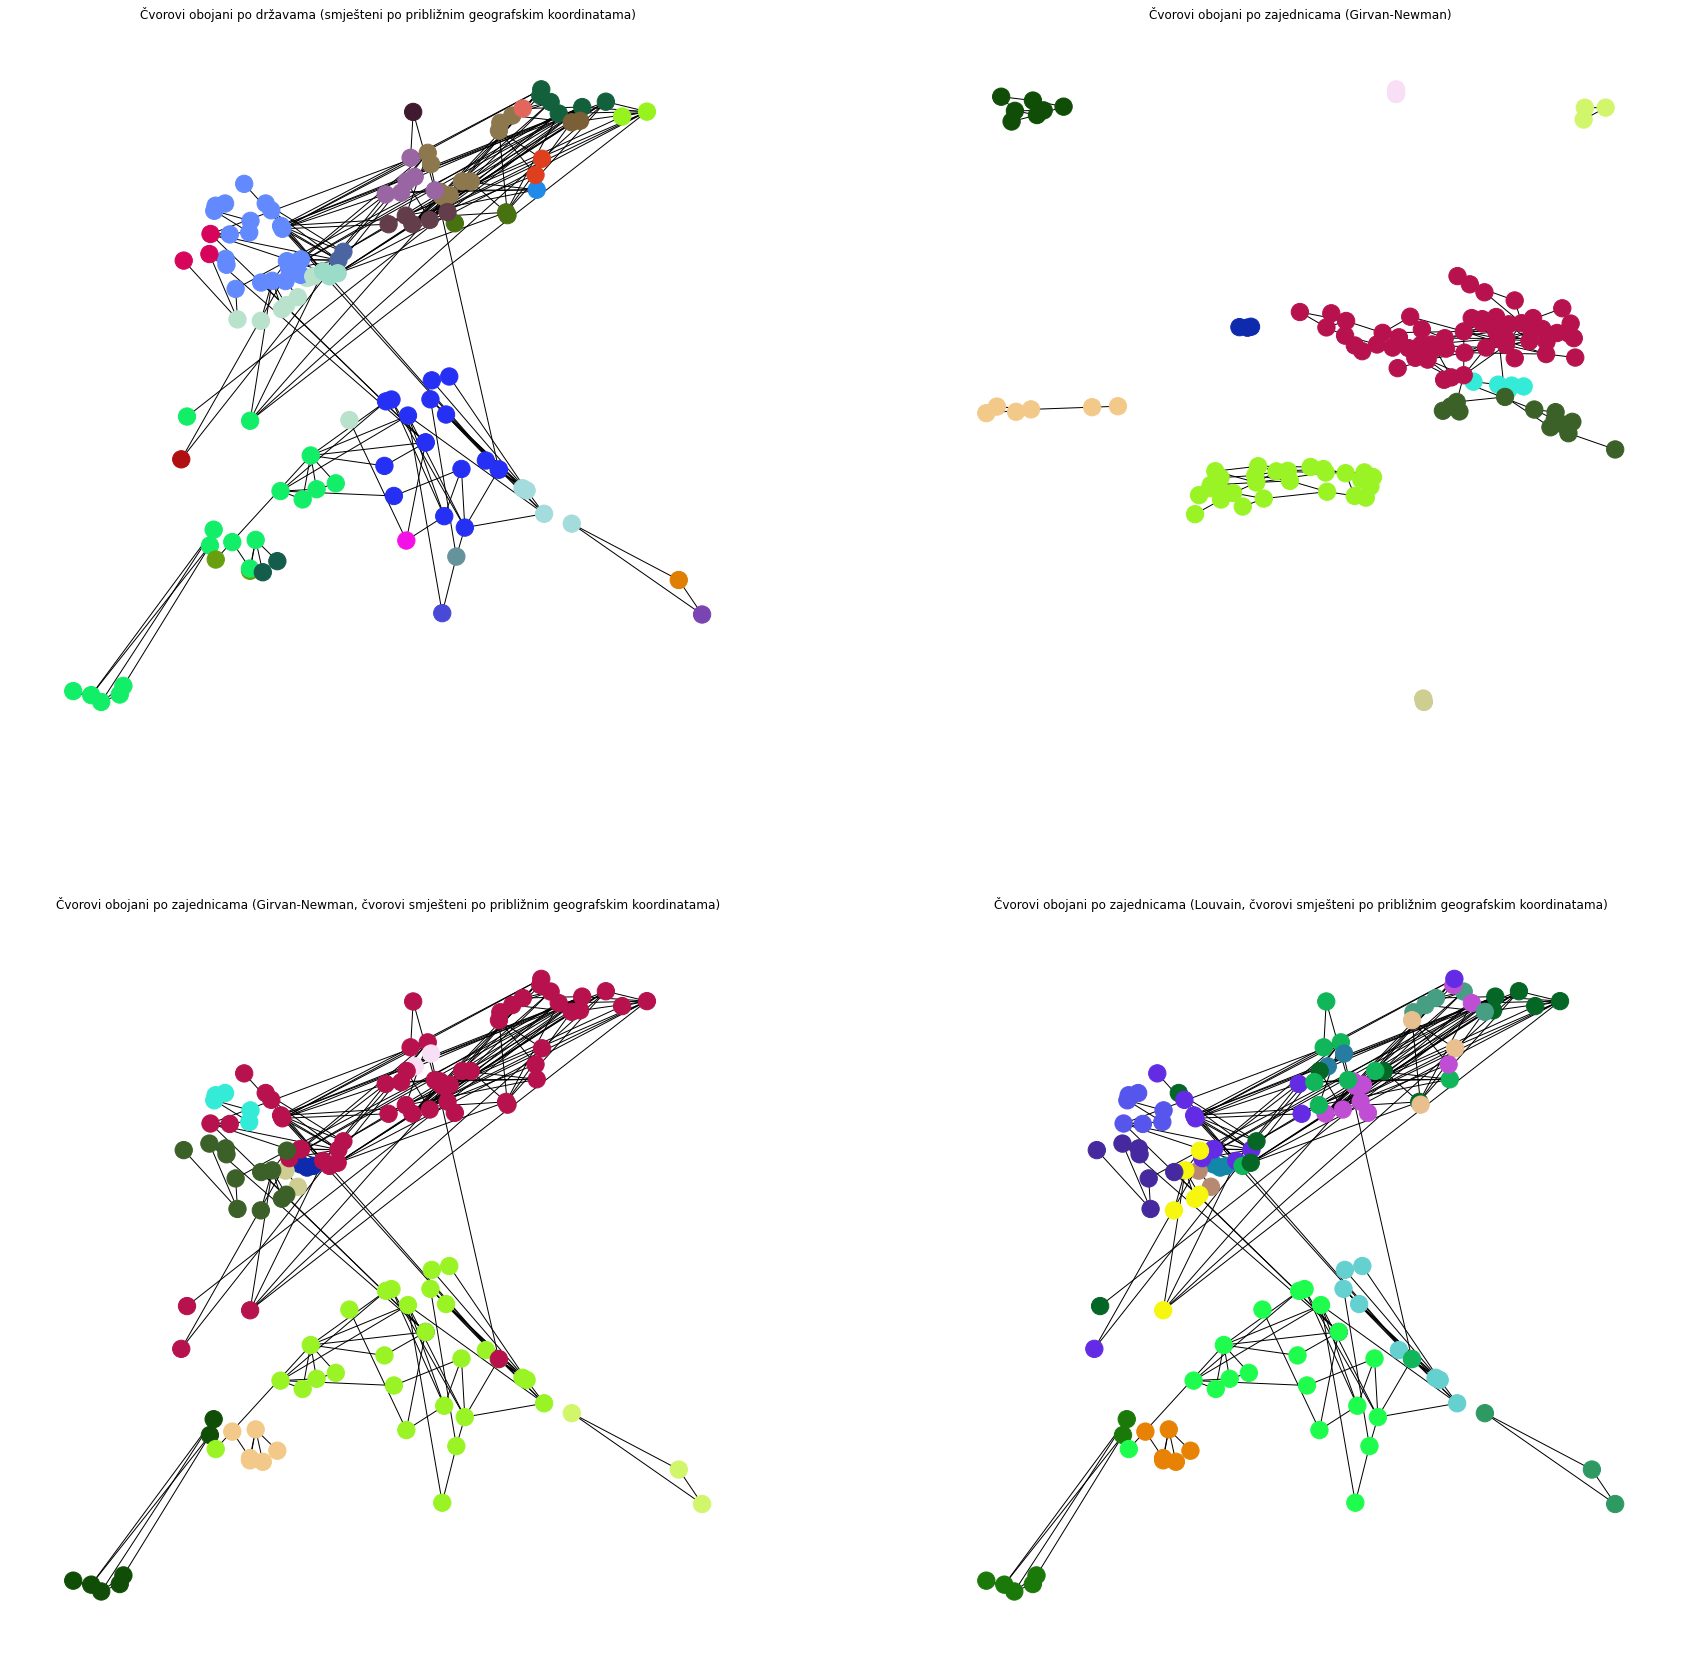

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(30, 30))
axs[0][0].set_title('Čvorovi obojani po državama (smješteni po približnim geografskim koordinatama)')
axs[0][1].set_title('Čvorovi obojani po zajednicama (Girvan-Newman)')
axs[1][0].set_title('Čvorovi obojani po zajednicama (Girvan-Newman, čvorovi smješteni po približnim geografskim koordinatama)')
axs[1][1].set_title('Čvorovi obojani po zajednicama (Louvain, čvorovi smješteni po približnim geografskim koordinatama)')


nx.draw(G, pos=coords, node_color=get_attribute_map(G, nodes, 'country_color'), ax=axs[0][0])
nx.draw_spring(G, node_color=get_attribute_map(G, nodes, 'gn_community_color'), ax=axs[0][1])
nx.draw(G, pos=coords, node_color=get_attribute_map(G, nodes, 'gn_community_color'), ax=axs[1][0])
nx.draw(G, pos=coords, node_color=get_attribute_map(G, nodes, 'l_community_color'), ax=axs[1][1])


In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(
    nodes, geometry=gpd.points_from_xy(nodes.lng, nodes.lat)
)

es = edges \
    .join(nodes[['label', 'pos']].rename(columns={'label': 'source', 'pos': 'source_pos'}), on='source', rsuffix='_node') \
    .join(nodes[['label', 'pos']].rename(columns={'label': 'target', 'pos': 'target_pos'}), on='target', rsuffix='_node') \
    .drop(['source', 'target', 'source_node', 'target_node'], axis=1)

ns = nodes.set_index('pos')
ns = ns[['country', 'country_color', 'gn_community', 'l_community', 'gn_community_color', 'l_community_color']].drop_duplicates()

G = nx.from_pandas_edgelist(es, 'source_pos', 'target_pos', edge_attr='weight')
nx.set_node_attributes(G, ns.to_dict('index'))

def plot_gdf(ax, gdf, category, edges=False, title=None):
    world.plot(ax=ax)
    ax.set_ylim((20, 75))
    ax.set_xlim((-25, 40))

    gdf_column = getattr(gdf, category)
    category_color = '{}_color'.format(category)
    for category in gdf_column.unique():
        plot_df = gdf[gdf_column == category]
        plot_df.plot(ax=ax, color=plot_df[category_color], label=category)
    
    ax.legend()
    ax.set_title(title)
    if edges:
        positions = {n: [n[0], n[1]] for n in list(G.nodes)}
        nx.draw(G, positions, ax=ax, node_size=0, node_color='red')

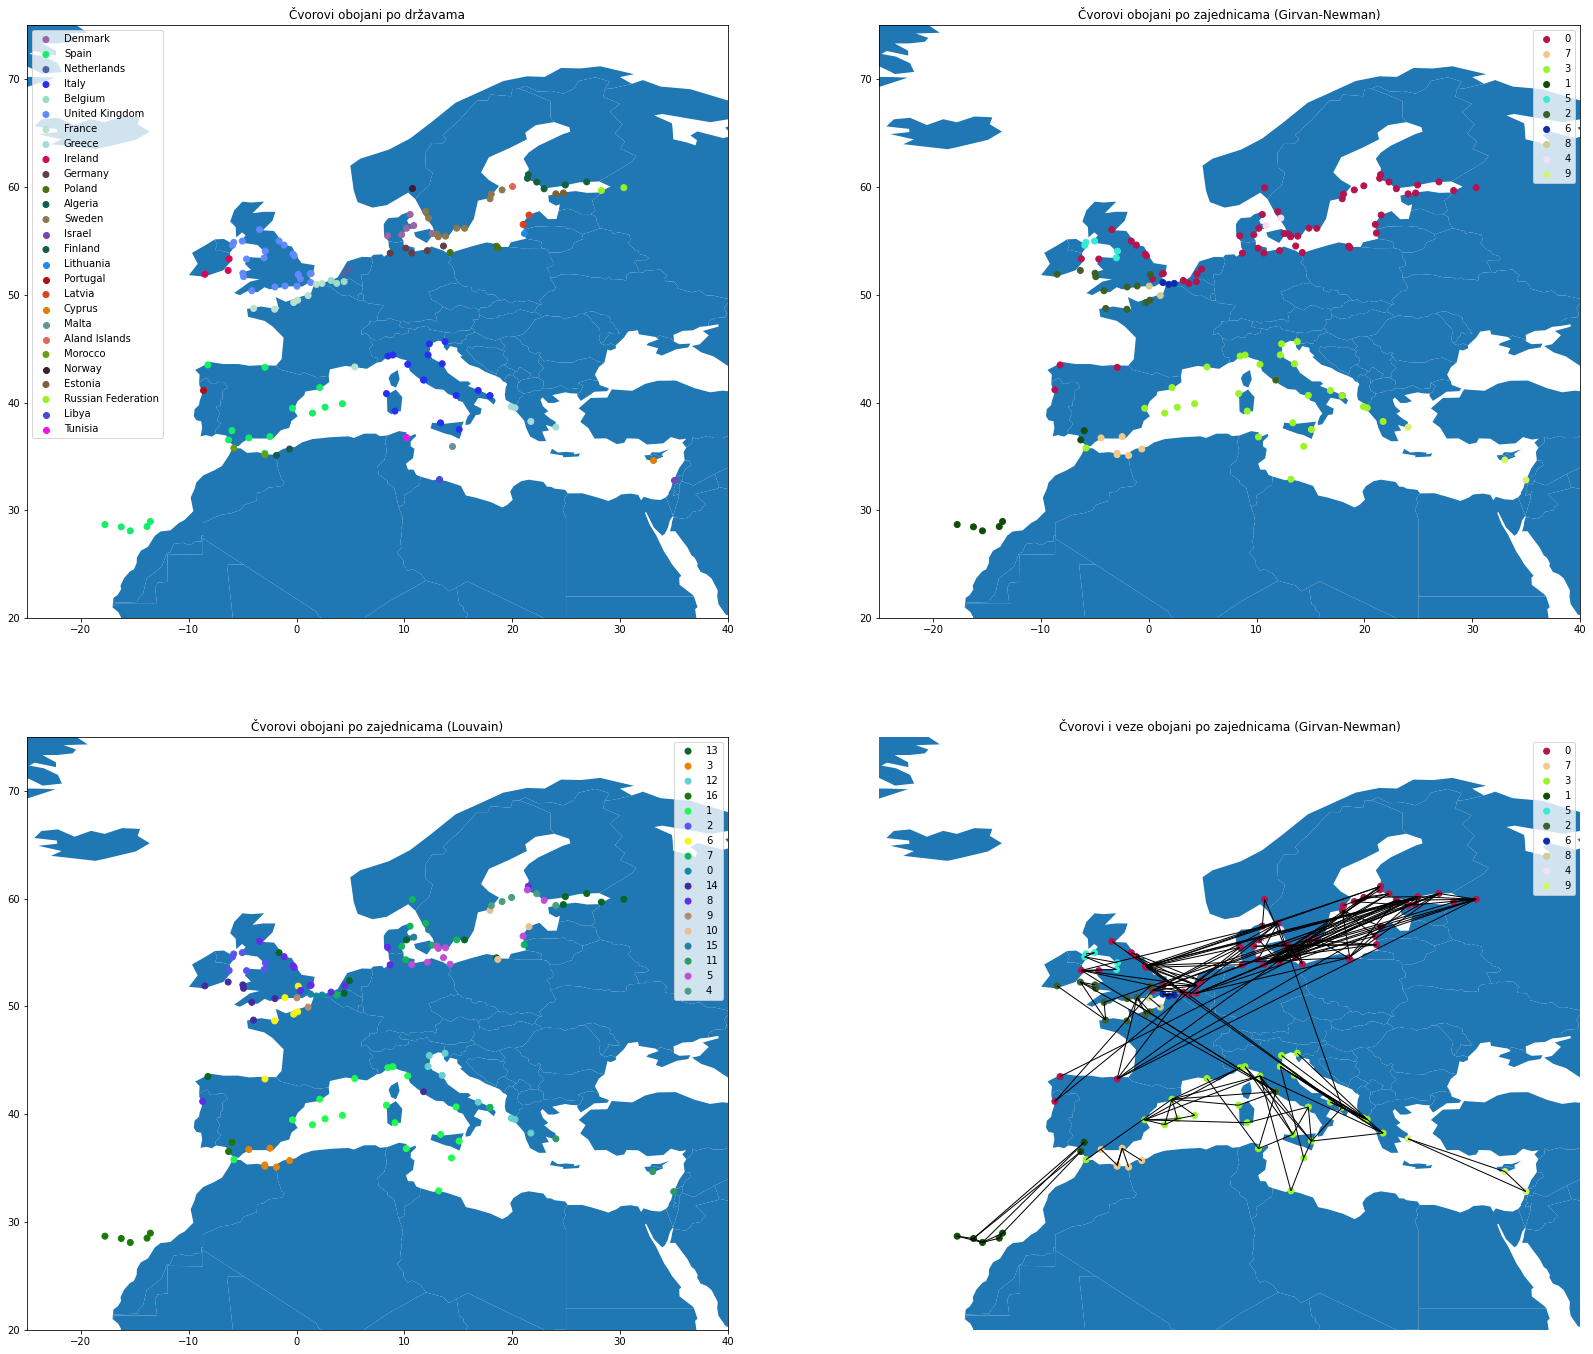

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(28, 24))

plot_gdf(axs[0][0], gdf, category='country', title='Čvorovi obojani po državama')
plot_gdf(axs[0][1], gdf, category='gn_community', title='Čvorovi obojani po zajednicama (Girvan-Newman)')
plot_gdf(axs[1][0], gdf, category='l_community', title='Čvorovi obojani po zajednicama (Louvain)')
plot_gdf(axs[1][1], gdf, category='gn_community', edges=True, title='Čvorovi i veze obojani po zajednicama (Girvan-Newman)')
#plt.legend()
plt.show()

### 4. (Globalna razina) Koje države pripadaju kojim zajednicima?

In [8]:
nodes[['gn_community', 'country']].groupby(['gn_community', 'country']).size().sort_index()

gn_community  country           
0             Aland Islands          1
              Belgium                3
              Denmark                5
              Estonia                2
              Finland                6
              Germany                5
              Ireland                1
              Italy                  1
              Latvia                 2
              Lithuania              1
              Netherlands            2
              Norway                 1
              Poland                 3
              Portugal               1
              Russian Federation     2
              Spain                  2
              Sweden                 9
              United Kingdom         9
1             Spain                  7
2             France                 4
              Ireland                2
              Italy                  1
              United Kingdom         6
3             France                 1
              Greece           

Zajednice zatim možemo proizvoljno preimenovati (Baltičke zemlje, Mediteranske zemlje, Engleski kanal...).

### 5. (Lokalna razina - čvor) Koje države najviše prometuju brodskim prijevozom?

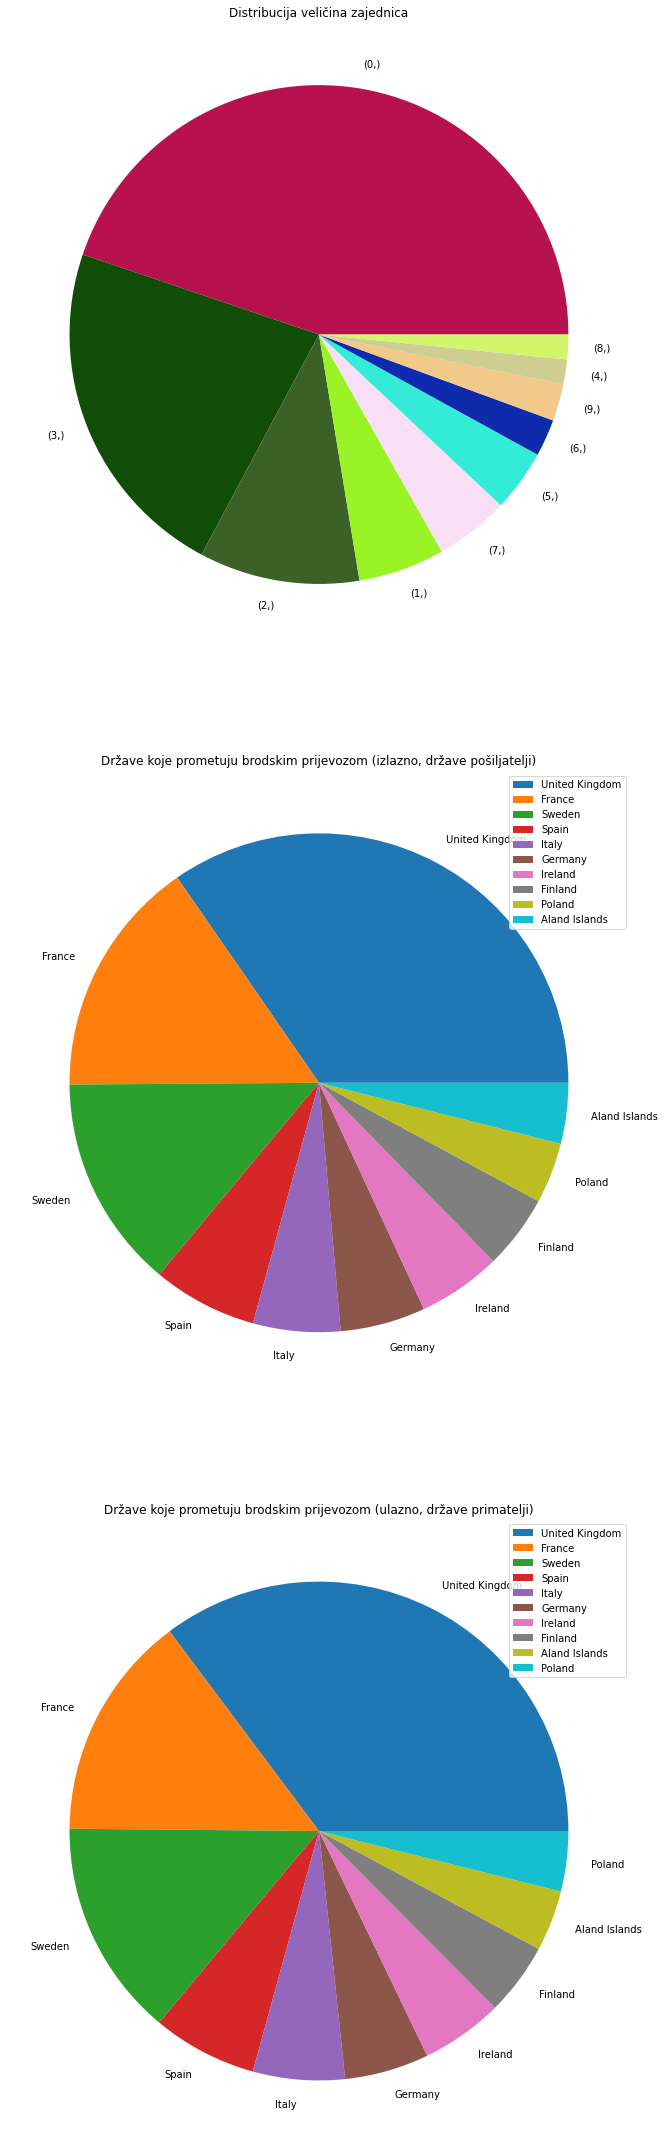

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=1, facecolor='white', figsize=(13, 39))
nodes[['gn_community']].value_counts().plot(kind='pie', ax=ax[0], colors=nodes.sort_values(by='gn_community')['gn_community_color'].unique())
most_traveled_edges.groupby('source_country').agg(weight=('weight', sum)).sort_values('weight', ascending=False).head(10).plot(kind='pie', ax=ax[1], subplots=True)
most_traveled_edges.groupby('target_country').agg(weight=('weight', sum)).sort_values('weight', ascending=False).head(10).plot(kind='pie', ax=ax[2], subplots=True)

ax[0].set_ylabel(None)
ax[0].set_title('Distribucija veličina zajednica')

ax[1].set_ylabel(None)
ax[1].set_title('Države koje prometuju brodskim prijevozom (izlazno, države pošiljatelji)')

ax[2].set_ylabel(None)
ax[2].set_title('Države koje prometuju brodskim prijevozom (ulazno, države primatelji)')

plt.show()

## 6. (Lokalna razina) Kroz kojih 25 luka prolazi najviše ruta?

In [10]:
G = nx.from_pandas_edgelist(edges, 'source', 'target', edge_attr='weight')
nx.set_node_attributes(G, nodes[['pos']].to_dict('index'))

sorted([("{}, {}".format(nodes.loc[deg[0]]['country'], nodes.loc[deg[0]]['city']), deg[1]) for deg in G.degree()], key=lambda x: x[1], reverse=True)[:25]

[('Finland, Helsingfors', 13),
 ('Germany, Lübeck', 12),
 ('Russian Federation, Saint Petersburg', 9),
 ('Sweden, Göteborg', 8),
 ('Netherlands, Rotterdam', 8),
 ('Greece, Igoumenitsa', 8),
 ('Spain, Barcelona', 8),
 ('United Kingdom, Immingham', 7),
 ('United Kingdom, Kingston upon Hull', 7),
 ('Belgium, Brugge', 7),
 ('United Kingdom, TILBURY', 7),
 ('Finland, Kotka', 7),
 ('Ireland, Dublin', 6),
 ('Germany, Rostock', 6),
 ('Poland, Gdynia', 6),
 ('Finland, Hanko', 6),
 ('Italy, Centro - S. Cristoforo', 6),
 ('Italy, LIVORNO', 6),
 ('Belgium, Antwerpen', 6),
 ('United Kingdom, Portsmouth', 5),
 ('Greece, Patra', 5),
 ('Spain, Valencia', 5),
 ('Spain, Bilbao', 5),
 ('Spain, Las Palmas de Gran Canaria', 5),
 ('Finland, Rauma', 5)]

### 7. (Lokalna razina - veza, Središnja razina - skup veza) Koje su najprometnije veze?

In [11]:
most_traveled_edges.head(20)

,source,target,weight,source_pos,source_country,target_pos,target_country
0,P17,P26,444,"(1.852055, 50.958102)",France,"(1.3134, 51.12787)",United Kingdom
1,P26,P17,402,"(1.3134, 51.12787)",United Kingdom,"(1.852055, 50.958102)",France
2,P26,P28,152,"(1.3134, 51.12787)",United Kingdom,"(2.366667, 51.05)",France
3,P28,P26,152,"(2.366667, 51.05)",France,"(1.3134, 51.12787)",United Kingdom
4,P27,P47,130,"(-6.248889, 53.333056)",Ireland,"(-4.63303, 53.30944)",United Kingdom
5,P47,P27,130,"(-4.63303, 53.30944)",United Kingdom,"(-6.248889, 53.333056)",Ireland
6,P16,P58,92,"(-5.02688, 54.97647)",United Kingdom,"(-5.82362, 54.8578)",United Kingdom
7,P58,P16,92,"(-5.82362, 54.8578)",United Kingdom,"(-5.02688, 54.97647)",United Kingdom
8,P108,P124,82,"(14.24757, 53.91003)",Poland,"(13.820415, 55.429659)",Sweden
14,P124,P108,80,"(13.820415, 55.429659)",Sweden,"(14.24757, 53.91003)",Poland


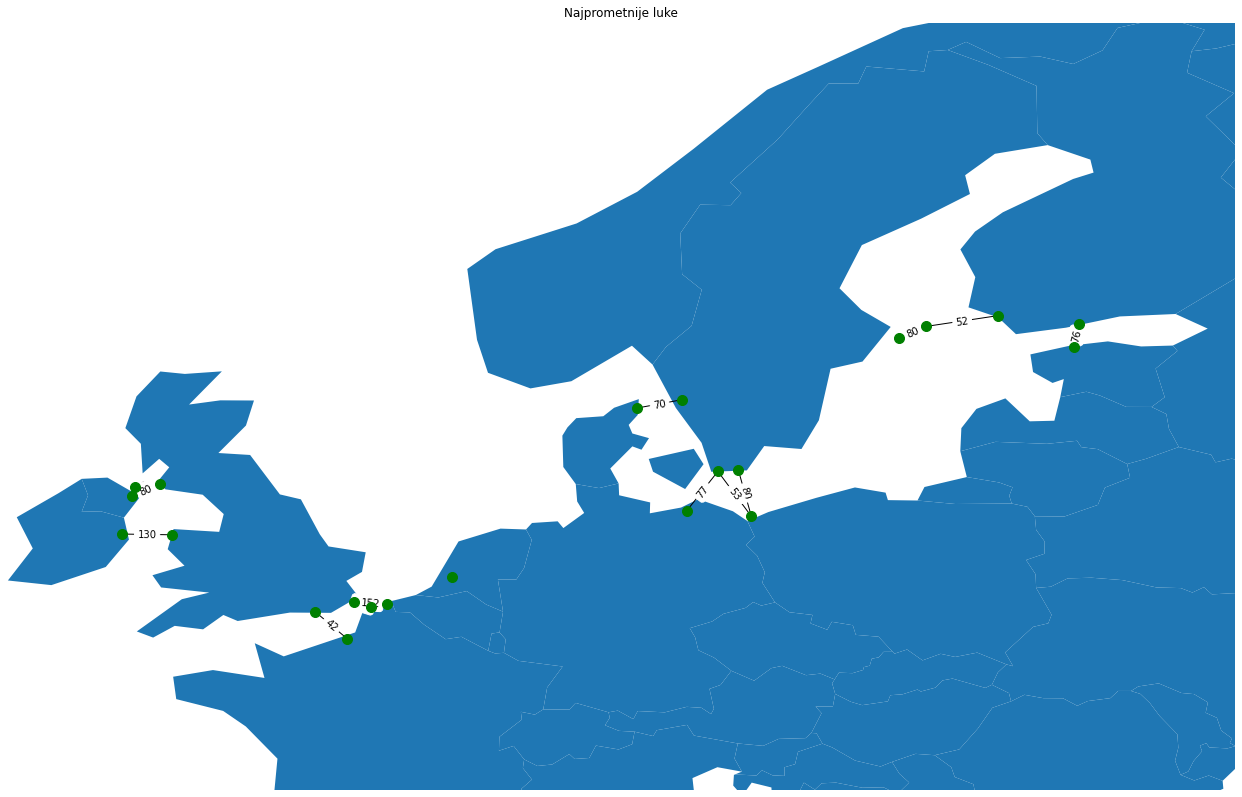

In [12]:
def plot_subset_gdf(ax, gdf, xlim, ylim, subset_edges, title=None):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax)

    ax.set_title(title)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    subset_gdf = gdf[(gdf.label.isin(subset_edges.source)) & (gdf.label.isin(subset_edges.target))]
    subset_gdf.plot(ax=ax)

    G = nx.from_pandas_edgelist(es, 'source_pos', 'target_pos', edge_attr='weight')
    nx.set_node_attributes(G, ns.to_dict('index'))

    keep_edges = list(subset_edges.set_index(['source_pos', 'target_pos']).index)
    G.remove_edges_from([edge for edge in G.edges if edge not in keep_edges])
    remove_nodes = list(filter(lambda x: x not in list(subset_gdf.pos.values), G.nodes))
    G.remove_nodes_from(remove_nodes)
    positions = {n: [n[0], n[1]] for n in G.nodes}
    
    nx.draw(G, positions, ax=ax, node_size=100, node_color='green')
    nx.draw_networkx_edge_labels(G, positions, ax=ax, edge_labels=nx.get_edge_attributes(G, 'weight'))

fig, ax = plt.subplots(1, figsize=(22, 15))
# ax.set_ylim((20, 75))
# ax.set_xlim((-25, 40))
#plot_subset_gdf(ax, gdf, xlim=(-25, 40), ylim=(20, 75), subset_edges=most_traveled_edges.head(20), title="Najprometnije luke")
plot_subset_gdf(ax, gdf, xlim=(-10, 30), ylim=(45, 70), subset_edges=most_traveled_edges.head(30), title="Najprometnije luke")

plt.show()


C:\Users\AndreaHrelja\anaconda3\envs\geo\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
C:\Users\AndreaHrelja\anaconda3\envs\geo\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
C:\Users\AndreaHrelja\anaconda3\envs\geo\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


[]

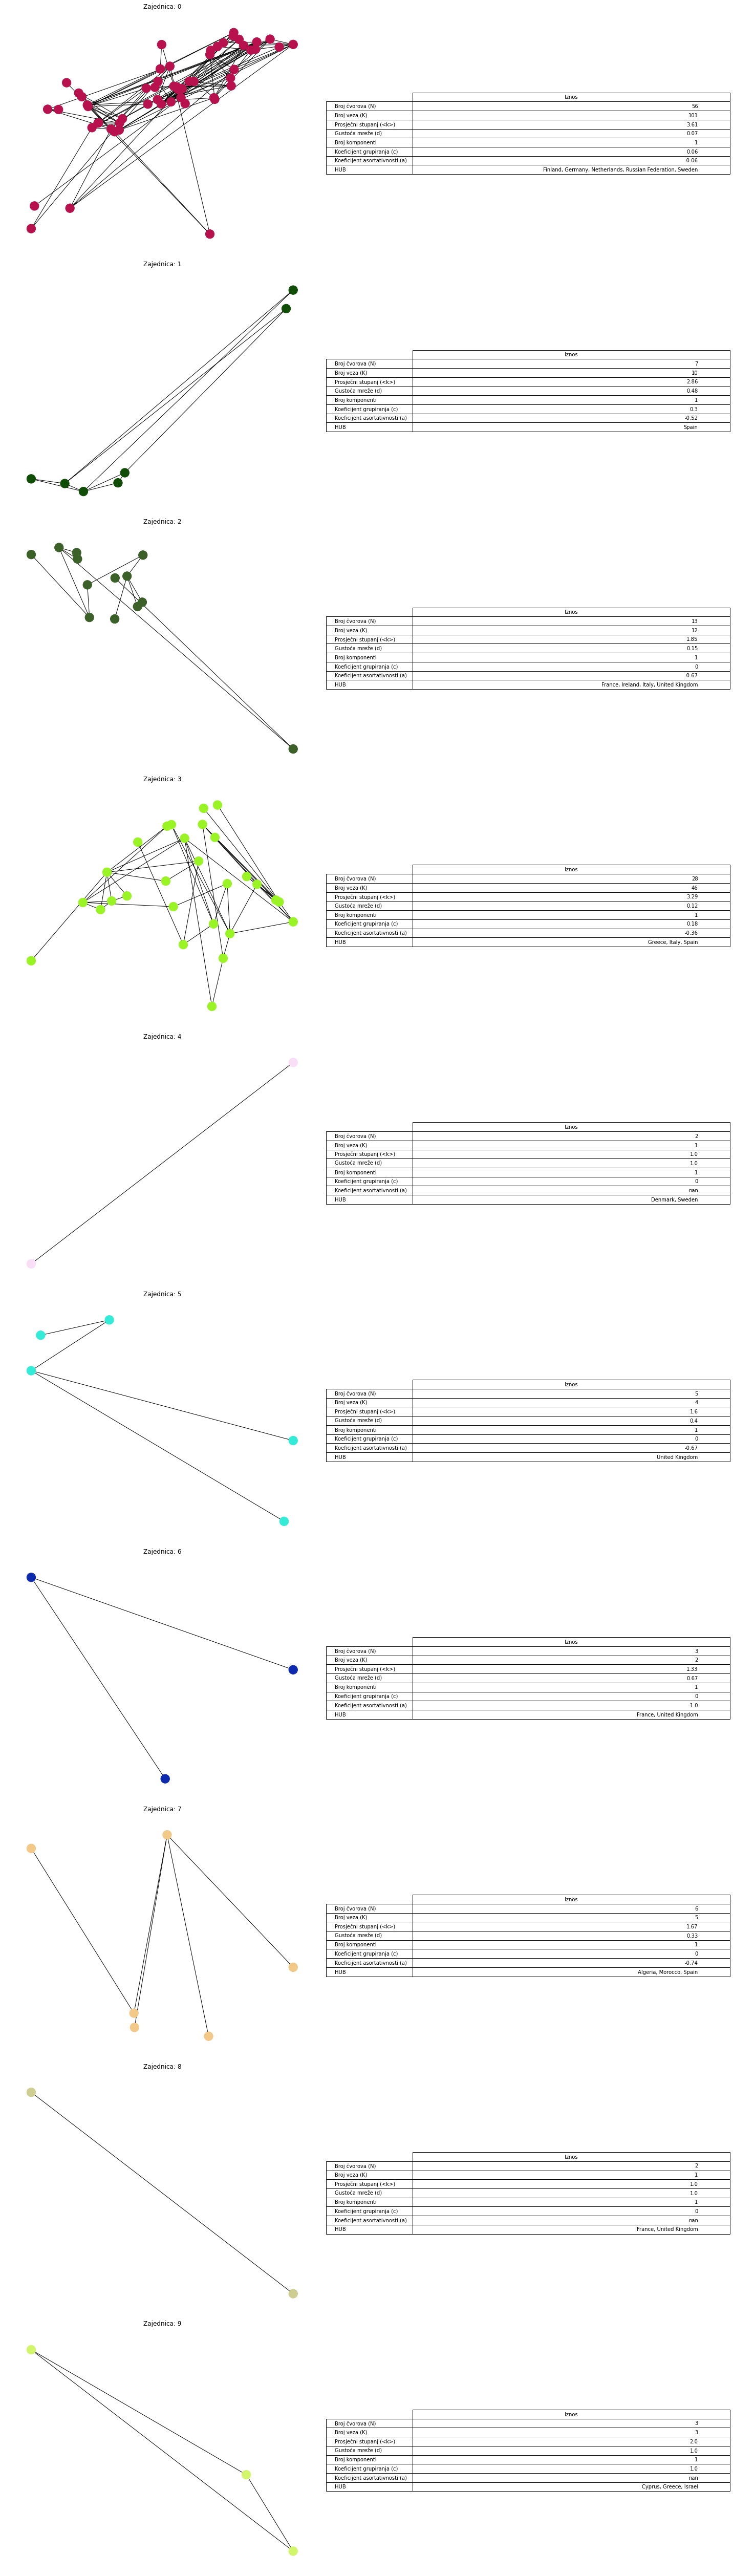

In [13]:
community_size = len(nodes.gn_community.unique())
fig, axs = plt.subplots(nrows=community_size, ncols=2, figsize=(20, 7*community_size))

for i, gn_community in enumerate(sorted(nodes.gn_community.unique())):
    nodes_f = nodes[nodes.gn_community == gn_community]
    g = nx.from_pandas_edgelist(edges[(edges.source.isin(nodes_f.label)) & (edges.target.isin(nodes_f.label))], 'source', 'target', edge_attr='weight')
    nx.draw(g, ax=axs[i][0], pos=coords, node_color=get_attribute_map(g, nodes, 'gn_community_color'))
    axs[i][0].set_title("Zajednica: {}".format(gn_community))
    measures_df = get_measures_df(g)
    axs[i][1].table(cellText=measures_df.values, rowLabels=measures_df.index, colLabels=['Iznos'], loc='center')
    
    


fig.tight_layout()
plt.plot()

## Zaključak

Za provedenu analizu korištene su razne metode za vizualizaciju koje su uvelike pomogle pri razumijevanju promatrane mreže. Provedena je analiza kroz tri razine, a lokalna je razina proširena atributima koji dodatno opisuju čvorove. Svaki je korak u analizi otvorio nova pitanja, a glavna saznanja iz ove analize su:

- veza Velike Britanije i Francuske najsnažija je veza od sviju ostalih veza  
- Baltičke zemlje koriste morski prijevoz u puno većoj količini od ostalih zemalja  
- promet koji luka u Rimu u Italiji vodi s Baltičkim zemljama je toliko velik da Rim pripada zajednici Baltičkih zemalja  
- Mediteransko područje sadrži mnoge male zajednice brodskog prijevoza  

Mreže i grafovi pružaju dodatnu, širu perspektivu nad značenjem podataka u odnosu na tablične podatke. Uz informacije o svakom promatranom entitetu (čvoru), dostupne su i informacije o njegovim odnosima s preostalim entitetima (čvorovima). Izrađenu je analizu moguće proširiti s raznim pitanjima i dodatnim mjerama grafa. U svrhu pregleda mrežnih struktura i izrade završnog rada, iznesena su prethodno ispisana saznanja.